Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/30
100/100 [==============================] - 434s 4s/step - loss: 0.6246 - accuracy: 0.6435 - val_loss: 0.4018 - val_accuracy: 0.8250
Epoch 2/30
100/100 [==============================] - 24s 236ms/step - loss: 0.4907 - accuracy: 0.7585 - val_loss: 0.3506 - val_accuracy: 0.8400
Epoch 3/30
100/100 [==============================] - 23s 227ms/step - loss: 0.4499 - accuracy: 0.7855 - val_loss: 0.3253 - val_accuracy: 0.8480
Epoch 4/30
100/100 [==============================] - 23s 228ms/step - loss: 0.4275 - accuracy: 0.7955 - val_loss: 0.3299 - val_accuracy: 0.8480
Epoch 5/30
100/100 [==============================] - 23s 226ms/step - loss: 0.4190 - accuracy: 0.8045 - val_loss: 0.3012 - val_accuracy: 0.8630
Epoch 6/30
100/100 [==============================] - 23s 228ms/step - loss: 0.4003 - accuracy: 0.8155 - val_loss: 0.2960 - val_

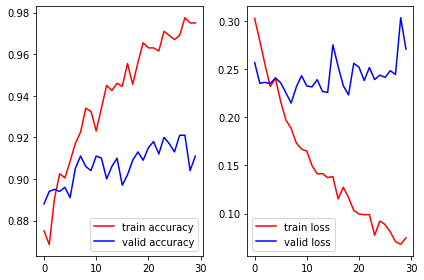

In [1]:
### 이미지 증식을 이용한 전이학습(fine tuning) ###

import os  # 폴더 경로 잡기 위해 필요
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/Colab임시폴더/cat_dog_small/train'
valid_dir = '/content/drive/MyDrive/Colab임시폴더/cat_dog_small/validation'

# 증식을 하는 ImageDataGenerator (train)
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,      # 0~30도 회전
                                   width_shift_range=0.1,  # 10% 비율로 가로로 움직임
                                   height_shift_range=0.1, # 10% 비율로 세로로
                                   zoom_range=0.2,         # 20% 범위내에서 확대, 축소
                                   horizontal_flip=True,  # 좌우반전 허용
                                   vertical_flip=True,    # 상하반전 허용
                                   fill_mode='nearest')   # 보정 -> 가까운 것으로

# 증식을 하지 않는 ImageDataGenerator (valid)
valid_datagen = ImageDataGenerator(rescale=1/255)

# 데이터를 directory부터 가져온다.
train_generator = train_datagen.flow_from_directory(train_dir,  # directory 명시
                                                    classes=['cats', 'dogs'],
                                                    # cats폴더에 있는 데이터는 label 0
                                                    # dogs폴더에 있는 데이터는 label 1
                                                    target_size=(150,150),  # 데이터 사이즈
                                                    batch_size=20,  # 한번에 가져오는 데이터 개수
                                                    class_mode='binary')  # 2진분류
                                                    # 다중분류시 categorical
    
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    classes=['cats', 'dogs'],
                                                    target_size=(150,150),
                                                    batch_size=20,
                                                    class_mode='binary')
                                                    
# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False  # Convolution layer 안의 parameter 동결!

# print(model_base.summary())

### model 구현 ###
model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4*4*512,)))   # ?

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

# print(model.summary())

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=1)

###### 여기까지 수행하면 classifier가 학습된다! ######

model_base.trainable = True   # 동결이 해제된다!

for layer in model_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True   # 동결을 푼다
    else:
        layer.trainable = False  # 동결

model.compile(optimizer=Adam(learning_rate=1e-5),  # 미세조정시 learning_rate를 더 작게
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 재학습을 진행
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=valid_generator,
                    validation_steps=50,
                    verbose=1)


### history 객체를 이용해서 결과 그래프를 그려보자! ###
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [1]:
# from tensorflow.keras.applications import VGG16

# # Pretrained Network
# model_base = VGG16(weights='imagenet',
#                    include_top=False,
#                    input_shape=(150,150,3))

# print(model_base.summary())

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              